In [1]:
# -*- coding: utf-8 -*-
from matplotlib import pyplot as plt
from pathlib import Path
import torch
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
from src.utils.data_modules import RoadDataset
from src.utils.train_modules import TrainEpoch,ValidEpoch
from src.utils.augmentations import get_augmentation
from src.visualization import visualize
import pathlib
import segmentation_models_pytorch as smp
import os
from torch.utils.data import DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage.morphology import skeletonize, skeletonize_3d
import numpy as np
import random

In [2]:
import torch
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
working_path = pathlib.Path().resolve()
path_object = pathlib.Path(working_path)
parent_path = path_object.parent
data_path = os.path.join(parent_path, "data/")
train_dataset = RoadDataset(data_path,
                            split="train",
                            transform=get_augmentation(augmentation="Combine4",img_size=416),
                            step_factor=2,
                            test_split=0.15,
                            seed=42,
                            preprocess=None,
                            external=None
                            )
valid_dataset = RoadDataset(data_path,
                            split="val",
                            transform=get_augmentation(augmentation="Validation",img_size=416),
                            step_factor=1,
                            test_split=0.15,
                            seed=42,
                            )
train_loader = DataLoader(train_dataset,
                          batch_size=16,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True)
valid_loader = DataLoader(valid_dataset,
                          batch_size=16,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True)

In [63]:
test=train_masks[0]

In [66]:
len(test.shape)

3

In [305]:
H_in=416
W_in= 416
p =[10,10]
k = [21,21]
d=[1,1]

H_out=H_in+2*p[0]-d[0]*(k[0]-1)
W_out=W_in+2*p[1]-d[1]*(k[1]-1)

print(H_out)
print(W_out)

416
416


In [259]:
416+2*1-2*(3-1)-1

413

In [312]:
def soft_erode(img):
    if len(img.shape)==4:
        p1 = -F.max_pool2d(-img, (3,1), (1,1), (1,0),dilation=(1,1))
        p2 = -F.max_pool2d(-img, (1,3), (1,1), (0,1),dilation=(1,1))
        return torch.min(p1,p2)
    elif len(img.shape)==5:
        p1 = -F.max_pool3d(-img,(3,1,1),(1,1,1),(1,0,0))
        p2 = -F.max_pool3d(-img,(1,3,1),(1,1,1),(0,1,0))
        p3 = -F.max_pool3d(-img,(1,1,3),(1,1,1),(0,0,1))
        return torch.min(torch.min(p1, p2), p3)


def soft_dilate(img):
    if len(img.shape)==4:
        return F.max_pool2d(img, (3,3), (1,1), (1,1),dilation=(1,1))
    elif len(img.shape)==5:
        return F.max_pool3d(img,(3,3,3),(1,1,1),(1,1,1))


def soft_open(img):
    return soft_dilate(soft_erode(img))


def soft_skel(img, iter_):
    img1  =  soft_open(img)
    skel  =  F.relu(img-img1)
    for j in range(iter_):
        img  =  soft_erode(img)
        img1  =  soft_open(img)
        delta  =  F.relu(img-img1)
        skel  =  skel +  F.relu(delta-skel*delta)
    return skel

In [340]:
range(416*415,416*416)

range(172640, 173056)

In [338]:
t[:,1:415,1:415].shape

torch.Size([1, 414, 414])

In [354]:
def nn(t,i,img_size=416):
    try:
        l= t[i-1]
    except:
        l=1
    try:
        r= t[i+1]
    except:
        r=1
    try:
        u= t[i-img_size]
    except:
        u=1
    try:
        ul= t[i-img_size-1]
    except:
        ul=1
    try:
        ur= t[i-img_size+1]
    except:
        ur=1
    try:
        d= t[i+img_size]
    except:
        d=1
    try:
        dl= t[i+img_size-1]
    except:
        dl=1
    try:
        dr= t[i+img_size+1]
    except:
        dr=1
    return l+r+u+ur+ul+d+dl+dr
    

In [ ]:
# and (i%416)=!0 and (i%417)=!0 and i not in range(0,416) and i not in range(416*415,416*416)
train_images,train_masks = next(iter(train_loader))
trues = soft_skel(train_masks, 50)

In [400]:

b = trues[0]
t = torch.flatten(b) 
C = torch.empty(t.size())
for i,pixel in enumerate(t):
    if int(pixel)==1:
        number_nn =nn(t,i)
    else:
        number_nn = 8
    if number_nn>1:
        C[i]=0
    else:
        C[i]=1


In [401]:
from collections import Counter
Counter(C.numpy().tolist())

Counter({0.0: 172719, 1.0: 337})

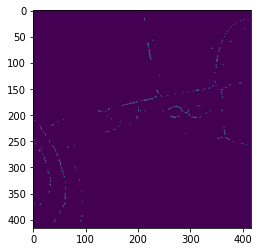

In [402]:
k = C.reshape(416,416)
k=k.numpy()
plt.imshow(k)

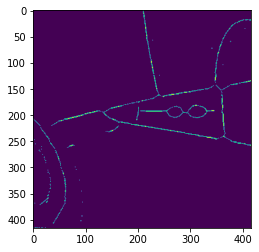

In [403]:
plt.imshow(b.numpy().reshape(416,416))

In [317]:
train_images,train_masks = next(iter(train_loader))
trues = soft_skel(train_masks, 50)
trues = trues.numpy()
trues = trues.reshape(trues.shape[0],416,416)

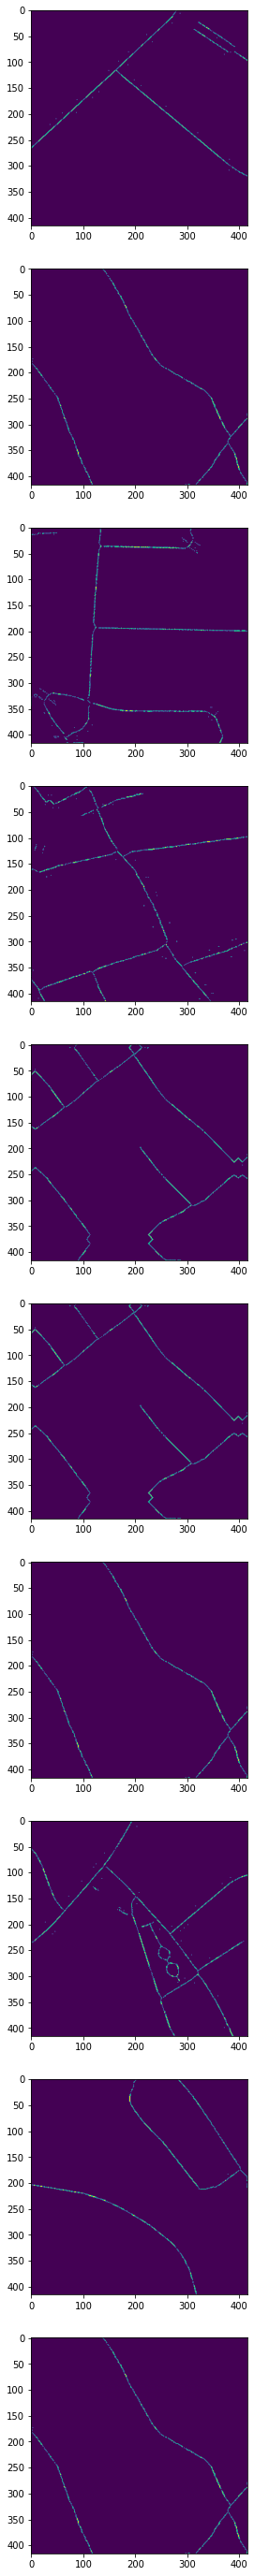

In [318]:
rows=10
cols = 1
fig,axs = plt.subplots(rows,cols,figsize=(20,50),tight_layout=False)
for r in range(rows):
    index=random.randint(0,len(trues)-1)
    mask = trues[index]
    axs[r].imshow(mask)
plt.show()

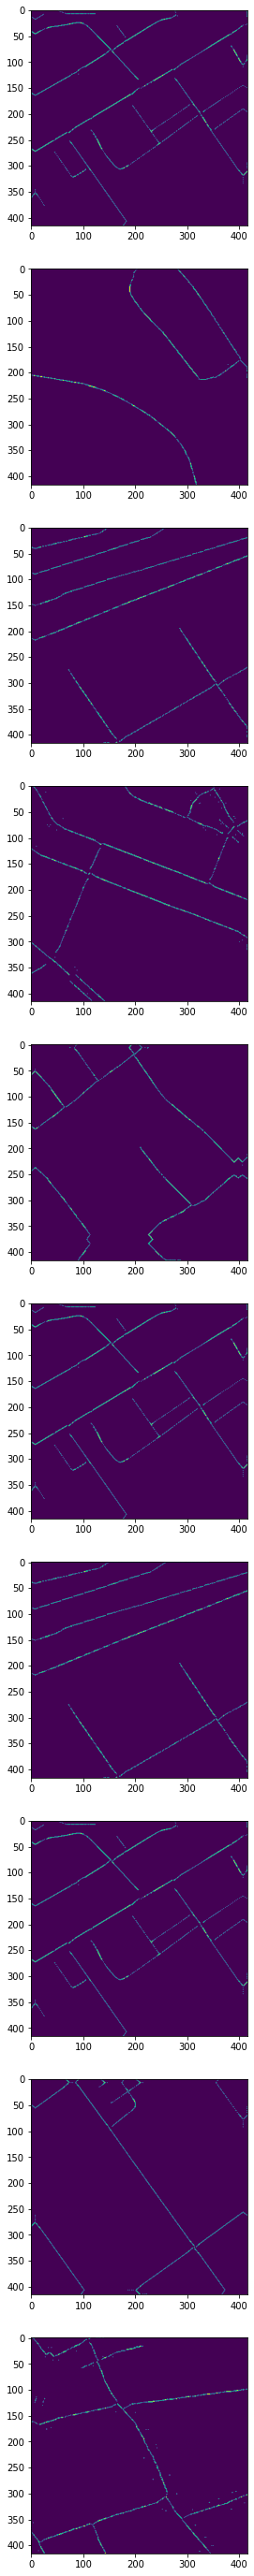

In [319]:
rows=10
cols = 1
fig,axs = plt.subplots(rows,cols,figsize=(20,50),tight_layout=False)
for r in range(rows):
    index=random.randint(0,len(trues)-1)
    mask = trues[index]
    axs[r].imshow(mask)
plt.show()

In [ ]:
plt.imshow(test)

In [ ]:
test.shape